## imports and stuff

the first part is preprocessing of LUNA. it has to be py2, since i don't have SImpleITK on py3

In [1]:
from cancer_utils import full_preprocess_img,preprocess_2

import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
output_path='/mnt/kaggle_lung_cancer/luna_tut_output/'
working_path = output_path
luna_subset_path='/mnt/gdrive/subset0/'
luna_full_path='/mnt/gdrive/'
import pandas as pd

%matplotlib inline

In [2]:
# Helper function to get rows in data frame associated 
# with each file
def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)
#
def make_mask(center,diam,z,width,height,spacing,origin):
    '''Center : centers of circles px -- list of coordinates x,y,z
    diam : diameters of circles px -- diameter
    widthXheight : pixel dim of image
    spacing = mm/px conversion rate np array x,y,z
    origin = x,y,z mm np.array
    z = z position of slice in world coordinates mm
        '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)


In [4]:
file_list=glob(luna_subset_path+"*.mhd")
file_list=glob(luna_full_path+"*/*.mhd")

# The locations of the nodes
luna_path='/mnt/gdrive/CSVFILES/'
df_node = pd.read_csv(luna_path+"annotations.csv")
df_node["file"] = df_node["seriesuid"].apply(get_filename)
df_node = df_node.dropna()

## pre-pre-processing: finding the nodules, and getting the relvant images

In [36]:
#####
#
# Looping over the image files - for finding nodules...
#




for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        # load the data once
        itk_img = sitk.ReadImage(img_file) 
        img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        # go through all nodes (why just the biggest?)
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            # just keep 3 slices
            imgs = np.ndarray([3,height,width],dtype=np.float32)
            masks = np.ndarray([3,height,width],dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                             int(v_center[2])+2).clip(0, num_z-1)): # clip prevents going out of bounds in Z
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask
                imgs[i] = img_array[i_z]
            imgs[imgs==-3024]=-1000
            np.save(os.path.join(output_path,"images_%04d_%04d.npy" % (fcount, node_idx)),imgs)
            np.save(os.path.join(output_path,"masks_%04d_%04d.npy" % (fcount, node_idx)),masks)

100%|██████████| 712/712 [03:17<00:00,  1.29it/s]


In [14]:
imgs[0],fcount, node_idx,file_list[0]

(array([[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ..., 
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.]], dtype=float32),
 88,
 873,
 '/mnt/gdrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd')

In [59]:
np.save(os.path.join(output_path,"images_%04d_%04d.npy" % (fcount, node_idx)),imgs)

(array([  1.68020000e+04,   1.90190000e+04,   1.97620000e+04,
          1.47620000e+04,   9.80800000e+03,   9.20300000e+03,
          9.55700000e+03,   1.08650000e+04,   1.02630000e+04,
          1.00610000e+04,   9.69800000e+03,   6.78300000e+03,
          4.63800000e+03,   3.02900000e+03,   2.31100000e+03,
          1.62900000e+03,   1.29600000e+03,   1.06500000e+03,
          9.71000000e+02,   7.81000000e+02,   6.68000000e+02,
          6.35000000e+02,   5.59000000e+02,   4.88000000e+02,
          4.41000000e+02,   4.96000000e+02,   3.54000000e+02,
          3.70000000e+02,   3.55000000e+02,   3.87000000e+02,
          3.06000000e+02,   3.34000000e+02,   2.75000000e+02,
          2.52000000e+02,   2.41000000e+02,   2.45000000e+02,
          2.27000000e+02,   2.13000000e+02,   1.94000000e+02,
          2.04000000e+02,   1.98000000e+02,   1.75000000e+02,
          1.87000000e+02,   1.80000000e+02,   1.94000000e+02,
          1.74000000e+02,   1.73000000e+02,   1.62000000e+02,
        

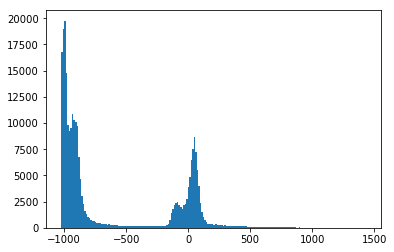

In [69]:
#print(file_list[0])
imgs_to_process = np.load(file_list[10]).astype(np.float64)
plt.hist(imgs_to_process[0].flatten(),bins=200)

image 0


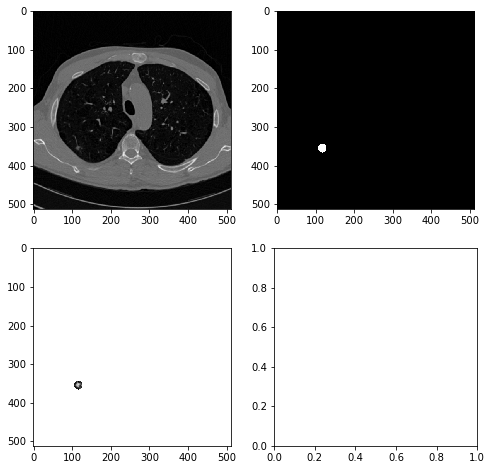

hit enter to cont : 
image 1


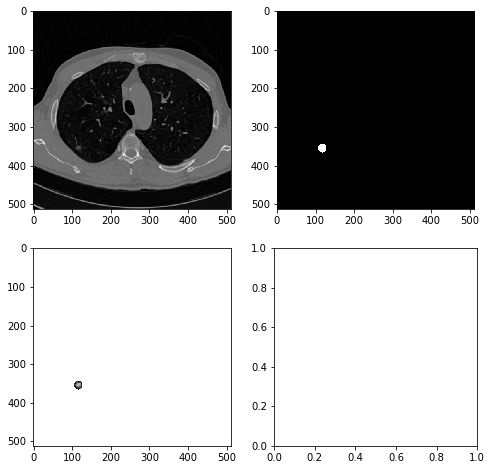

hit enter to cont : 
image 2


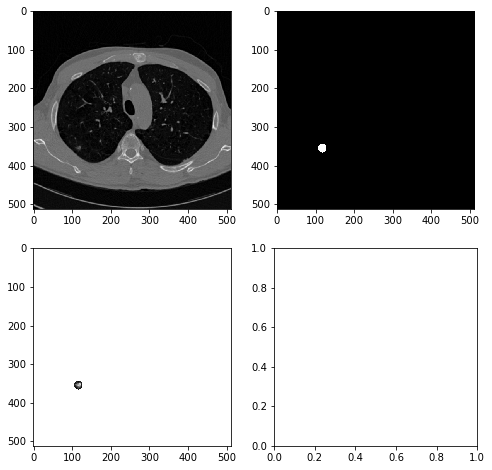

hit enter to cont : 


In [34]:


#just visualize 

imgs = np.load(output_path+'images_0000_0110.npy')
masks = np.load(output_path+'masks_0000_0110.npy')
for i in range(len(imgs)):
    print "image %d" % i
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(masks[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*masks[i],cmap='gray')
    plt.show()
    raw_input("hit enter to cont : ")

In [35]:
imgs.shape

(3, 512, 512)

## 1st step preprocess - make lungmasks

In [6]:
import numpy as np

npy_file_list=glob(working_path+"images_*.npy")

for img_file in npy_file_list:
    # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
    imgs_to_process = np.load(img_file).astype(np.float64) 
    print "on image", img_file
    mask_list=[]
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        #Standardize the pixel values
        mask=full_preprocess_img(img)
        mask_list.append(mask)
    np.save(img_file.replace("images","lungmask"),np.array(mask_list))
    

on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0691_0461.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0358_0842.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0073_0224.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0010_0035.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0708_0173.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0525_0336.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0536_0295.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0499_0454.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0685_0977.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0368_1045.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0669_0448.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0655_0476.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0045_0025.npy
on image /mnt/kaggle_lung_cancer/luna_tut_output/images_0368_1047.npy
on image /mnt/kaggle

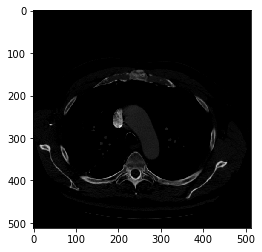

In [32]:
#img[img==-3024]=0
plt.imshow(imgs_to_process[1],cmap='gray')

In [31]:
imgs_to_process[1][imgs_to_process[1]<0]=0

(array([  4.20940000e+04,   5.17400000e+03,   1.67950000e+04,
          2.01890000e+04,   9.11500000e+03,   3.67100000e+03,
          2.04500000e+03,   1.36800000e+03,   9.81000000e+02,
          9.39000000e+02,   7.84000000e+02,   7.16000000e+02,
          7.04000000e+02,   8.06000000e+02,   9.21000000e+02,
          9.09000000e+02,   7.35400000e+03,   1.81080000e+04,
          1.06610000e+04,   8.06840000e+04,   1.79520000e+04,
          4.21400000e+03,   5.91300000e+03,   1.55700000e+03,
          1.32700000e+03,   1.13900000e+03,   1.02500000e+03,
          8.93000000e+02,   7.04000000e+02,   6.57000000e+02,
          5.03000000e+02,   4.39000000e+02,   4.19000000e+02,
          3.10000000e+02,   2.84000000e+02,   2.26000000e+02,
          1.30000000e+02,   8.60000000e+01,   9.50000000e+01,
          8.60000000e+01,   6.60000000e+01,   5.30000000e+01,
          2.30000000e+01,   5.00000000e+00,   5.00000000e+00,
          4.00000000e+00,   4.00000000e+00,   3.00000000e+00,
        

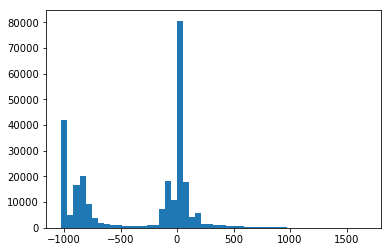

In [27]:
imgs_to_process[1][imgs_to_process[1]==-2048]=0
plt.hist(imgs_to_process[1].flatten(),bins=50)

## 2nd preprocessing - combine img and lungmask

In [18]:
#
#    Here we're applying the masks and cropping and resizing the image
#

lungmask_file_list=glob(working_path+"lungmask_*.npy")
out_images = []      #final set of images
out_nodemasks = []   #final set of nodemasks
for fname in lungmask_file_list:
    print "working on file ", fname
    imgs_to_process = np.load(fname.replace("lungmask","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        node_mask = node_masks[i]
        
        img = imgs_to_process[i]
        try:
            new_img,new_node_mask=preprocess_2(img,mask,node_mask)
        except:
            print('error in file',fname)
        out_images.append(new_img)
        out_nodemasks.append(new_node_mask)

num_images = len(out_images)
#
#  Writing out images and masks as 1 channel arrays for input into network
#
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(working_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(working_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(working_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(working_path+"testMasks.npy",final_masks[rand_i[:test_i]])

working on file  /mnt/kaggle_lung_cancer/luna_tut_output/lungmask_0633_0981.npy
working on file  /mnt/kaggle_lung_cancer/luna_tut_output/lungmask_0539_0108.npy
working on file  /mnt/kaggle_lung_cancer/luna_tut_output/lungmask_0057_0536.npy
working on file  /mnt/kaggle_lung_cancer/luna_tut_output/lungmask_0164_0667.npy
working on file  /mnt/kaggle_lung_cancer/luna_tut_output/lungmask_0316_0357.npy
working on file  /mnt/kaggle_lung_cancer/luna_tut_output/lungmask_0067_0297.npy
working on file  /mnt/kaggle_lung_cancer/luna_tut_output/lungmask_0087_0872.npy
working on file  /mnt/kaggle_lung_cancer/luna_tut_output/lungmask_0501_0506.npy
working on file  /mnt/kaggle_lung_cancer/luna_tut_output/lungmask_0207_0089.npy
working on file  /mnt/kaggle_lung_cancer/luna_tut_output/lungmask_0088_0965.npy
working on file  /mnt/kaggle_lung_cancer/luna_tut_output/lungmask_0582_0171.npy
working on file  /mnt/kaggle_lung_cancer/luna_tut_output/lungmask_0642_1147.npy
working on file  /mnt/kaggle_lung_cancer

In [17]:
preprocess_2(img,mask,node_mask)

## plots and stuff

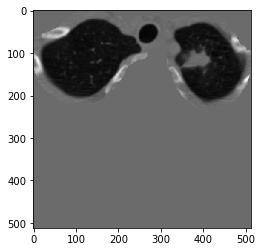

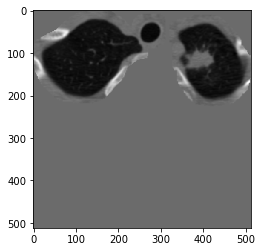

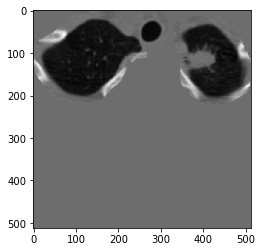

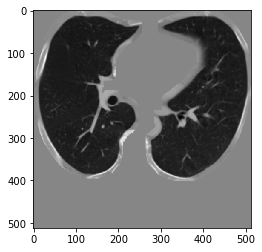

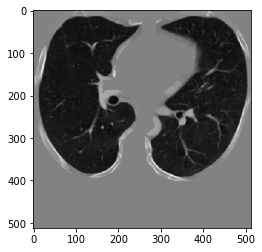

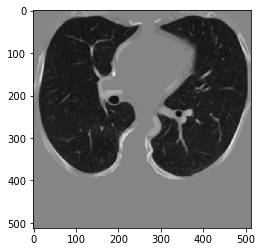

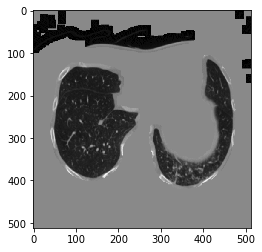

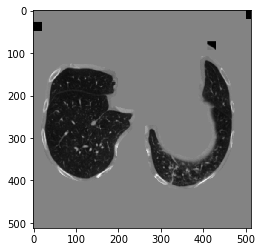

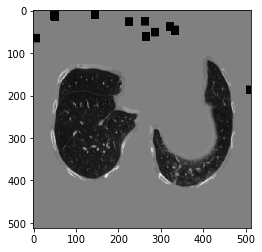

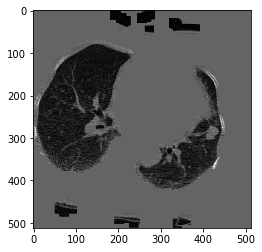

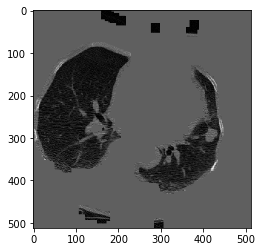

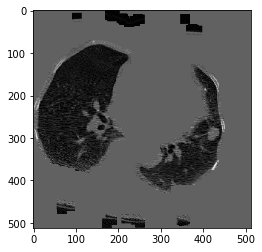

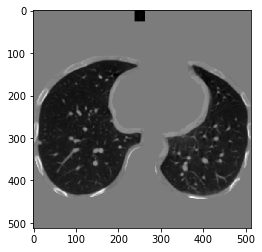

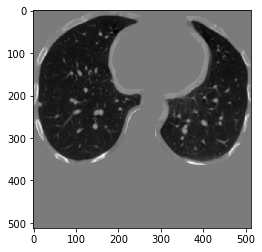

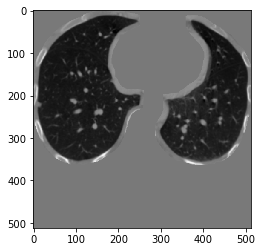

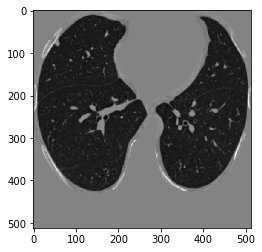

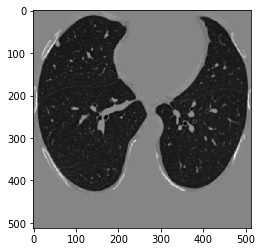

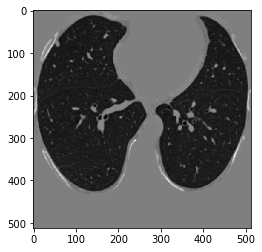

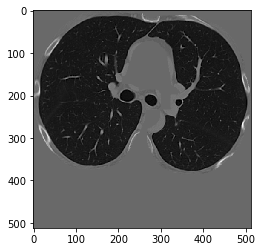

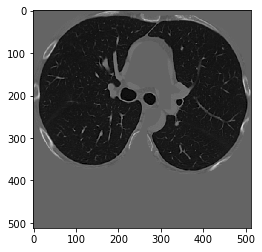

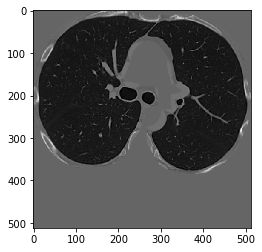

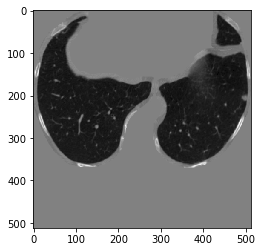

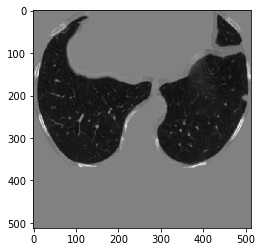

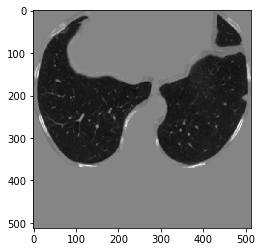

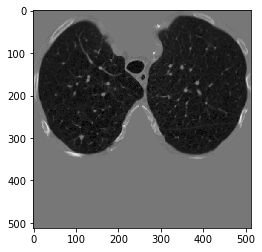

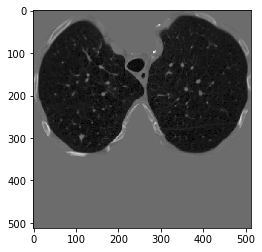

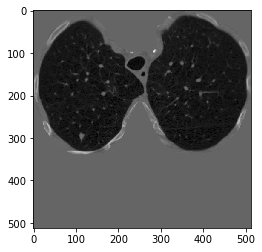

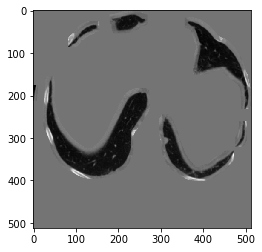

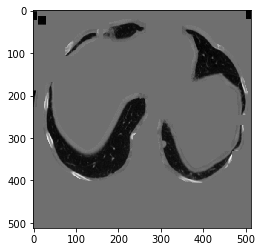

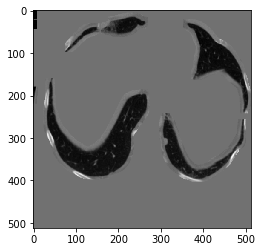

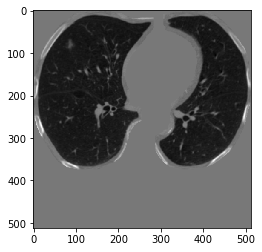

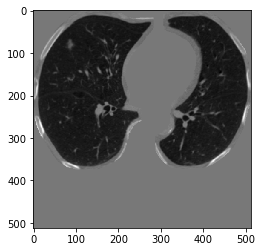

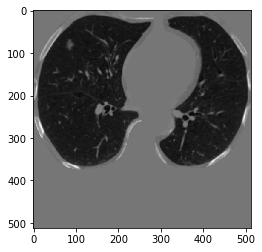

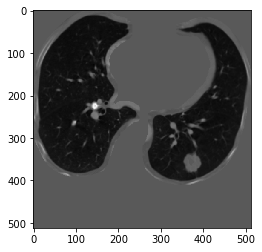

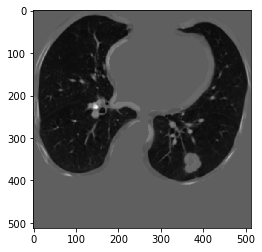

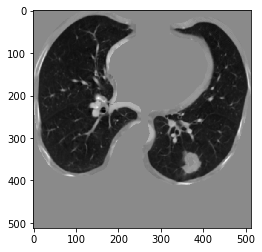

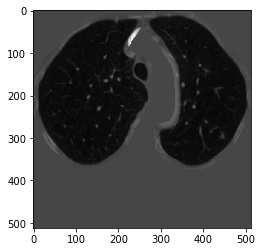

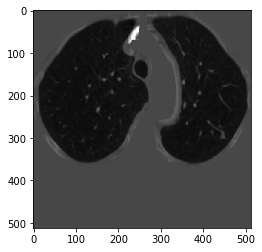

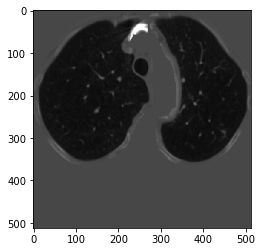

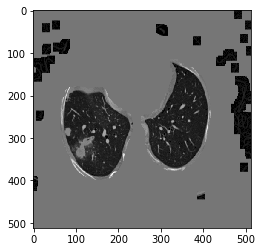

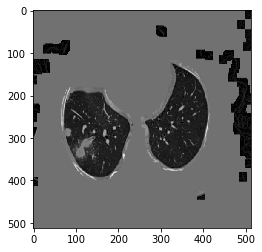

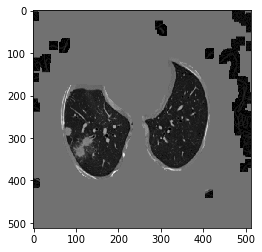

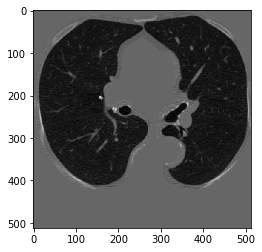

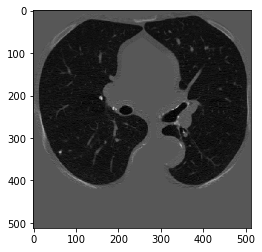

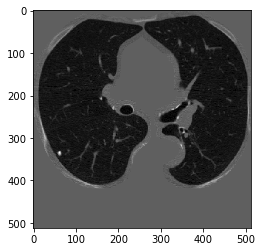

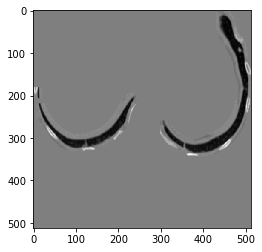

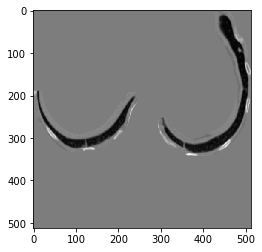

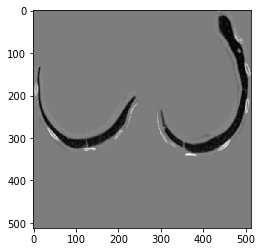

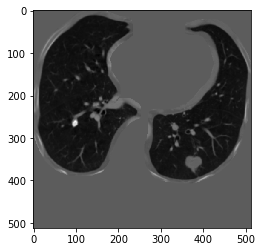

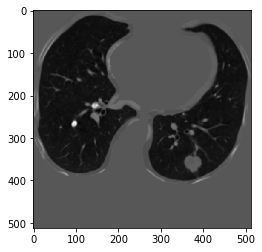

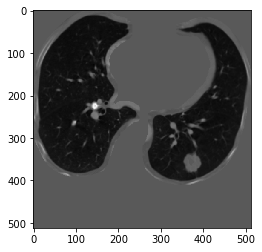

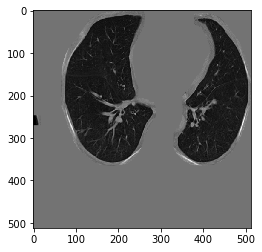

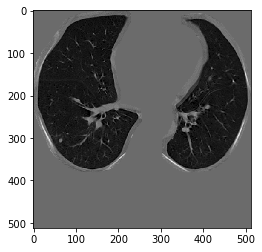

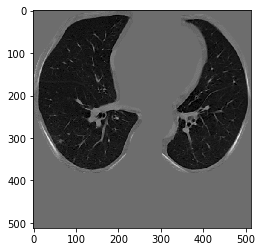

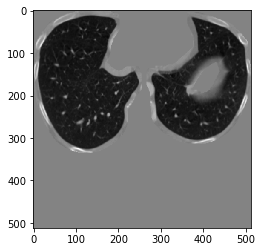

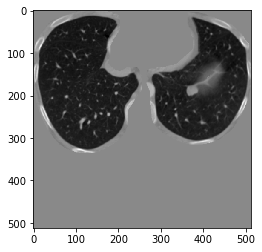

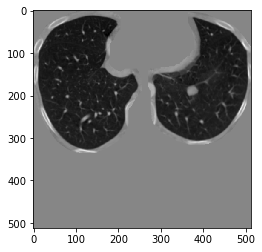

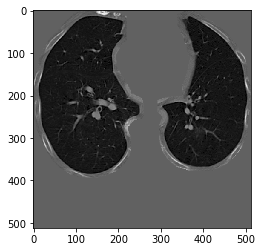

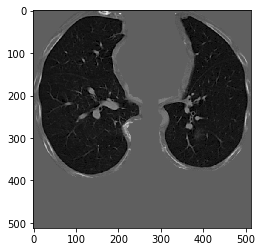

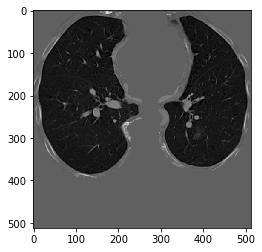

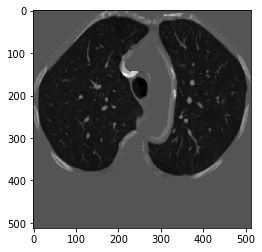

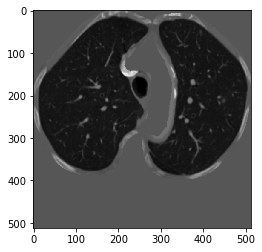

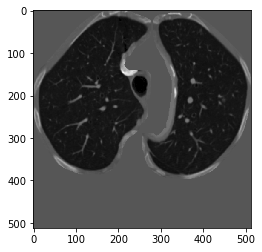

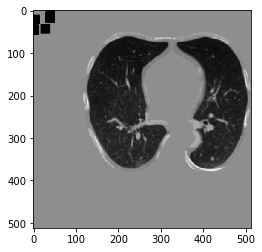

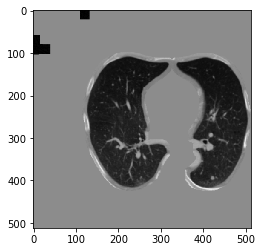

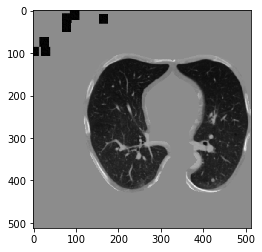

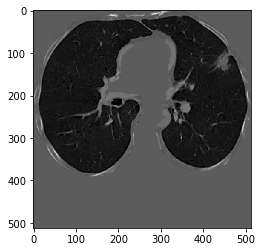

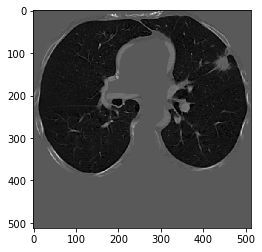

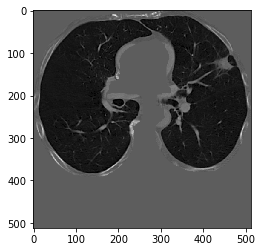

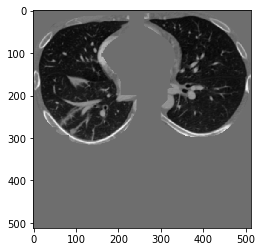

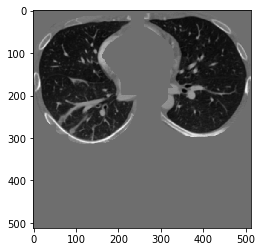

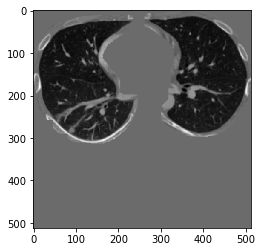

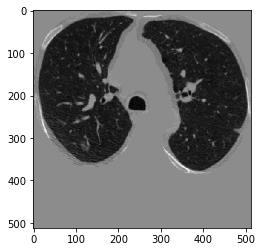

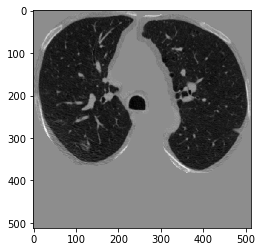

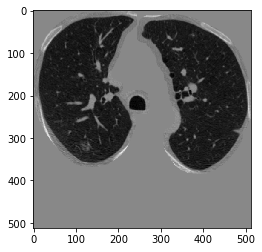

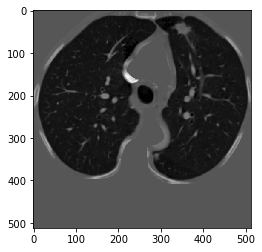

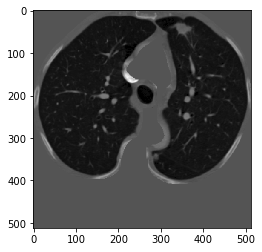

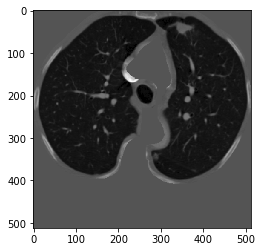

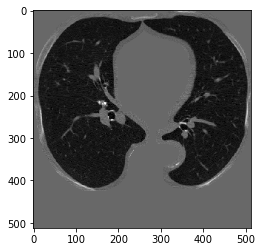

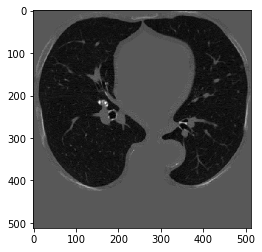

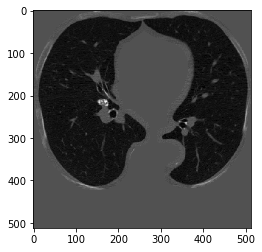

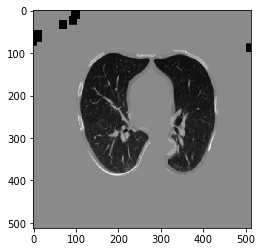

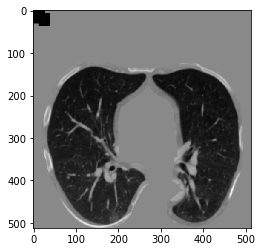

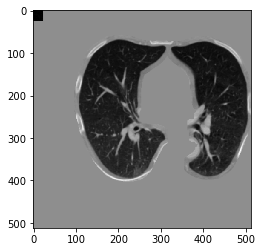

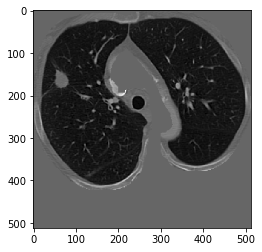

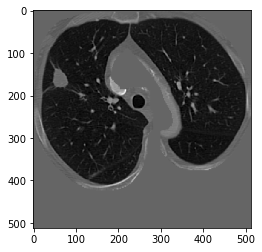

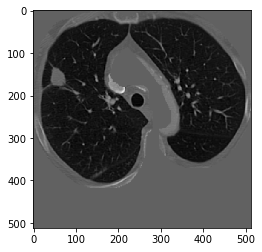

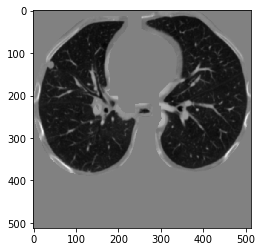

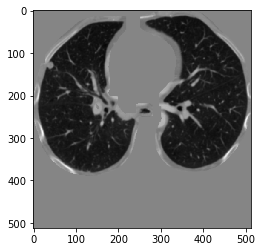

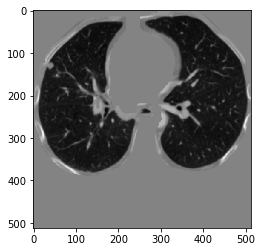

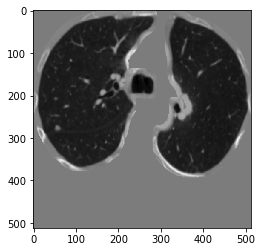

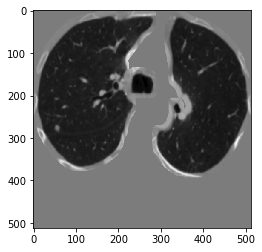

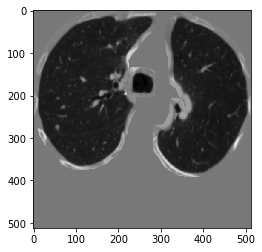

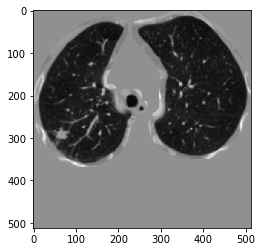

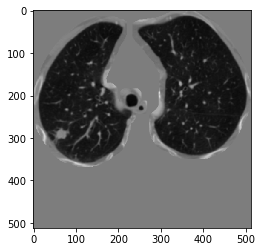

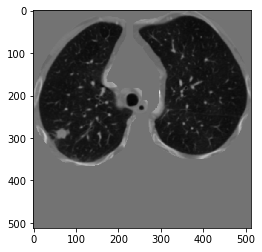

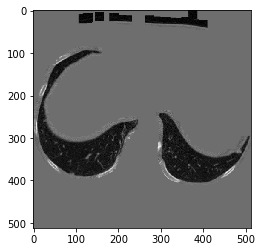

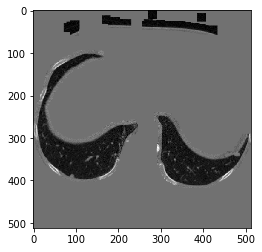

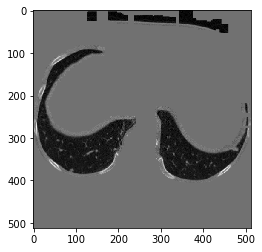

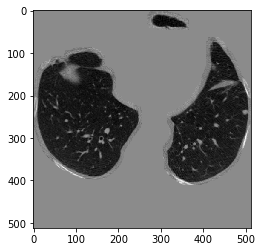

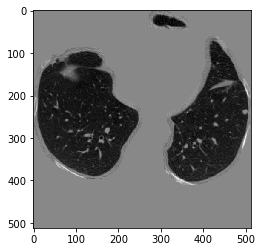

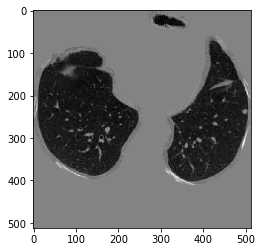

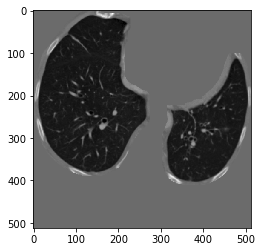

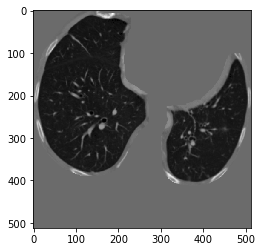

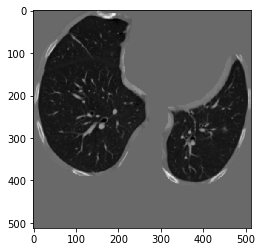

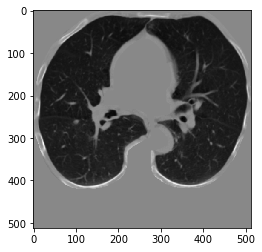

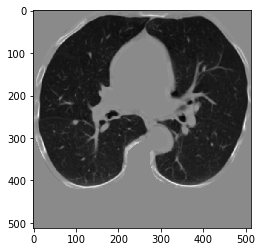

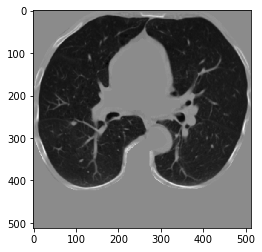

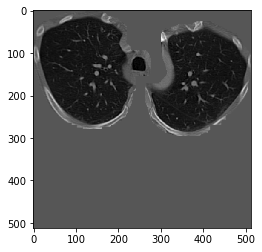

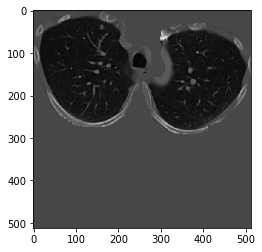

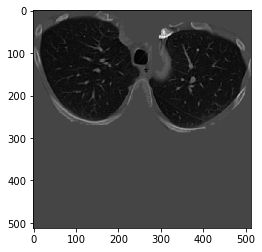

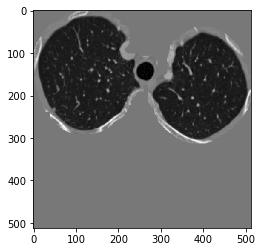

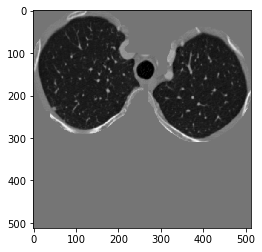

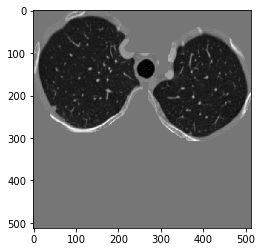

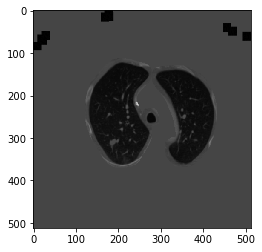

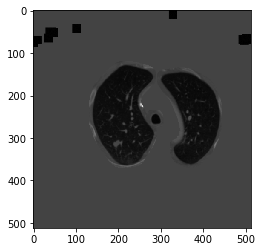

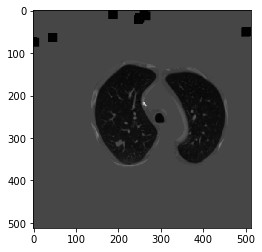

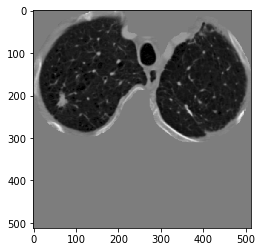

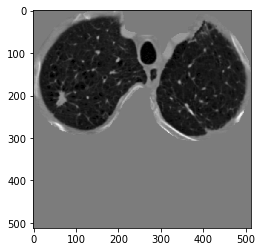

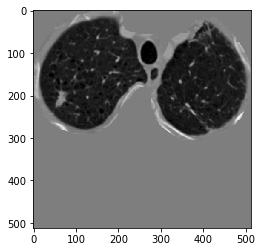

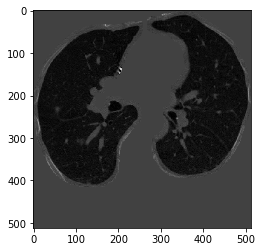

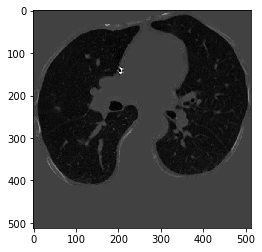

KeyboardInterrupt: 

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline
for i in range(len(final_masks)):
    plt.imshow(final_images[i][0],cmap='gray')
    plt.show()

In [45]:
imgs = np.load(working path+'images_0.npy')
lungmask = np.load(working_path+'lungmask_0.npy')
for i in range(len(imgs)):
    print "image %d" % i
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(lungmask[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*lungmask[i],cmap='gray')
    plt.show()
    raw_input("hit enter to cont : ")

SyntaxError: invalid syntax (<ipython-input-45-2aca21929fa4>, line 1)

In [24]:

imgs = np.load(working_path+"trainImages.npy")

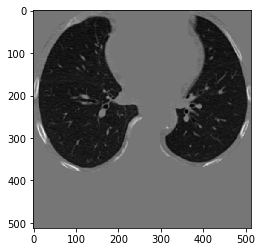

In [27]:
plt.imshow(imgs[0][0],cmap='gray')

## classifcation - return from second nb to py2

In [29]:
from classify_nodes import *

/home/ubuntu/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
